Automatically created module for IPython interactive environment


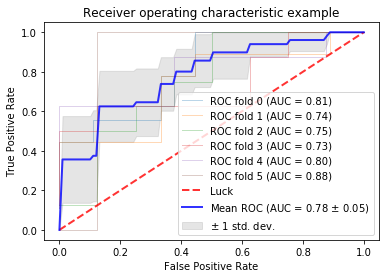

In [1]:
print(__doc__)

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Data IO and generation

# Import some data to play with
iris = datasets.load_iris()
X = iris.data
y = iris.target
X, y = X[y != 2], y[y != 2]
n_samples, n_features = X.shape

# Add noisy features
random_state = np.random.RandomState(0)
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Automatically created module for IPython interactive environment
Feature ranking:
1. feature 1 (0.306023)
2. feature 0 (0.130319)
3. feature 4 (0.118601)
4. feature 3 (0.092306)
5. feature 5 (0.056358)
6. feature 2 (0.055714)
7. feature 10 (0.026986)
8. feature 12 (0.026873)
9. feature 7 (0.026844)
10. feature 13 (0.026808)
11. feature 6 (0.026796)
12. feature 9 (0.026714)
13. feature 11 (0.026617)
14. feature 8 (0.026564)
15. feature 14 (0.026478)


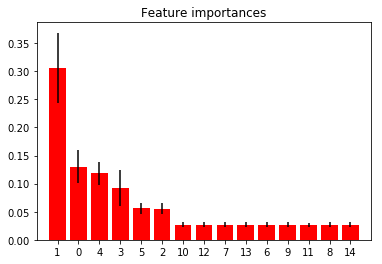

In [2]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=5000,
                           n_features=15,
                           n_informative=6,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Automatically created module for IPython interactive environment


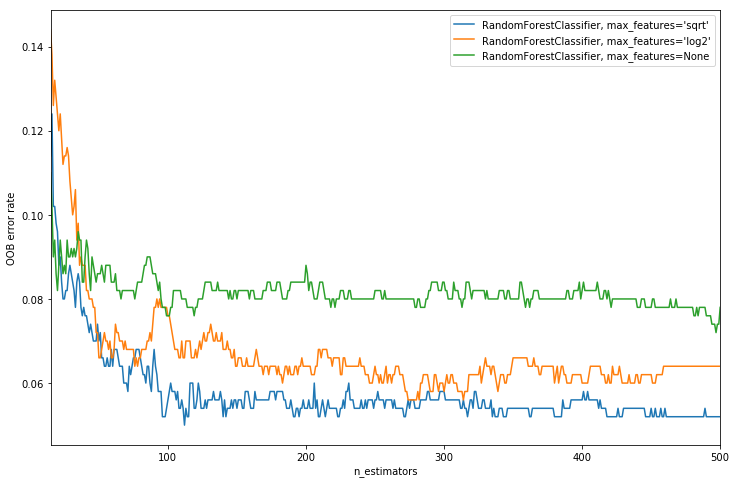

In [8]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

RANDOM_STATE = 123

# Generate a binary classification dataset.
X, y = make_classification(n_samples=500, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=RANDOM_STATE)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))
plt.figure(figsize=(12, 8))
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold, cross_val_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
# Generate simulation data
data = np.random.normal(0,1,(100,2))
label = (np.random.normal(0,1,(100))>0)*1
# scale data 
data = StandardScaler().fit_transform(data)
# Generate folds
kf = list(StratifiedKFold(label, n_folds=5, random_state=1988))
# Build a classifier
clf = LogisticRegression()
# Manually fit a score
train, test = kf[0]
X = data[train, :]
y = label[train]
clf.fit(X, y)
ypred = clf.predict(X)
print(roc_auc_score(y, ypred))
# Use cross_val_score for fit and score
print (cross_val_score(clf, data, label, cv = kf, scoring='roc_auc'))

0.53120978121
[ 0.59090909  0.41818182  0.64646465  0.62222222  0.43333333]


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold, cross_val_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
# Generate simulation data
data = np.random.normal(0,1,(100,2))
label = (np.random.normal(0,1,(100))>0)*1
# scale data 
data = StandardScaler().fit_transform(data)
# Generate folds
kf = list(StratifiedKFold(label, n_folds=5, random_state=1988))
# Build a classifier
clf = LogisticRegression()
# Manually fit a score
# train, test = kf[0]
# X = data[train, :]
# y = label[train]
# clf.fit(X, y)
# ypred = clf.predict(X)
# print(roc_auc_score(y, ypred))
# # Use cross_val_score for fit and score
# print(cross_val_score(clf, data, label, cv = kf, scoring='roc_auc'))

train, test = kf[0]
X = data[train, :]
y = label[train]
clf.fit(X, y)
y_pred = clf.predict_proba(data[test])
print(roc_auc_score(label[test], y_pred[:, 1]))
print(cross_val_score(clf, data, label, cv=kf, scoring='roc_auc'))
print(np.mean(cross_val_score(clf, data, label, cv = kf, scoring='roc_auc')))

0.509259259259
[ 0.50925926  0.51515152  0.4040404   0.2020202   0.21590909]
0.369276094276


In [1]:
import time
import numpy as np
from matplotlib import pyplot as plt
from keras.utils import np_utils
import keras.callbacks as cb
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras.datasets import mnist

Using TensorFlow backend.


In [2]:
class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

In [5]:
def load_data():
    print ('Loading data...')
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')

    X_train /= 255
    X_test /= 255

    y_train = np_utils.to_categorical(y_train, 10)
    y_test = np_utils.to_categorical(y_test, 10)

    X_train = np.reshape(X_train, (60000, 784))
    X_test = np.reshape(X_test, (10000, 784))

    print ('Data loaded.')
    return [X_train, X_test, y_train, y_test]

In [7]:
def init_model():
    start_time = time.time()
    print ('Compiling Model ... ')
    model = Sequential()
    model.add(Dense(500, input_dim=784))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(300))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(10))
    model.add(Activation('softmax'))

    rms = RMSprop()
    model.compile(loss='categorical_crossentropy', optimizer=rms, metrics=['accuracy'])
    print ('Model compield in {0} seconds'.format(time.time() - start_time))
    return model

In [8]:
def run_network(data=None, model=None, epochs=20, batch=256):
    try:
        start_time = time.time()
        if data is None:
            X_train, X_test, y_train, y_test = load_data()
        else:
            X_train, X_test, y_train, y_test = data

        if model is None:
            model = init_model()

        history = LossHistory()

        print ('Training model...')
        model.fit(X_train, y_train, nb_epoch=epochs, batch_size=batch,
                  callbacks=[history],
                  validation_data=(X_test, y_test), verbose=2)

        print ("Training duration : {0}".format(time.time() - start_time))
        score = model.evaluate(X_test, y_test, batch_size=16)

        print ("Network's test score [loss, accuracy]: {0}".format(score))
        return model, history.losses
    except KeyboardInterrupt:
        print (' KeyboardInterrupt')
        return model, history.losses

In [11]:
def plot_losses(losses):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(losses)
    ax.set_title('Loss per batch')
    fig.show()

In [9]:
data = load_data()
model, losses = run_network(data=data)

Loading data...
11476992/11490434 [============================>.] - ETA: 0sData loaded.
Compiling Model ... 
Model compield in 0.2513847351074219 seconds
Training model...


/opt/conda/lib/python3.6/site-packages/Keras-2.0.8-py3.6.egg/keras/models.py:852: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/20
10s - loss: 0.3586 - acc: 0.8890 - val_loss: 0.1545 - val_acc: 0.9508
Epoch 2/20
10s - loss: 0.1539 - acc: 0.9533 - val_loss: 0.0933 - val_acc: 0.9710
Epoch 3/20
10s - loss: 0.1128 - acc: 0.9665 - val_loss: 0.0841 - val_acc: 0.9751
Epoch 4/20
10s - loss: 0.0934 - acc: 0.9719 - val_loss: 0.0798 - val_acc: 0.9763
Epoch 5/20
10s - loss: 0.0784 - acc: 0.9764 - val_loss: 0.0782 - val_acc: 0.9779
Epoch 6/20
10s - loss: 0.0714 - acc: 0.9778 - val_loss: 0.0736 - val_acc: 0.9794
Epoch 7/20
10s - loss: 0.0623 - acc: 0.9810 - val_loss: 0.0692 - val_acc: 0.9811
Epoch 8/20
10s - loss: 0.0590 - acc: 0.9819 - val_loss: 0.0642 - val_acc: 0.9823
Epoch 9/20
10s - loss: 0.0532 - acc: 0.9843 - val_loss: 0.0768 - val_acc: 0.9799
Epoch 10/20
9s - loss: 0.0500 - acc: 0.9850 - val_loss: 0.0727 - val_acc: 0.9817
Epoch 11/20
9s - loss: 0.0473 - acc: 0.9858 - val_loss: 0.0794 - val_acc: 0.9823
Epoch 12/20
10s - loss: 0.0449 - acc: 0.9865 - val_loss: 0.

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


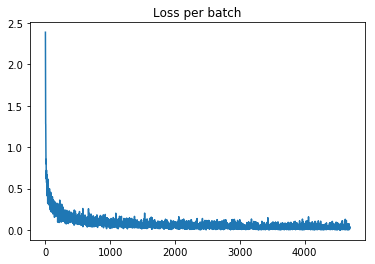

In [12]:
plot_losses(losses)

In [13]:
help(plt.figaspect)

Help on function figaspect in module matplotlib.figure:

figaspect(arg)
    Create a figure with specified aspect ratio.  If *arg* is a number,
    use that aspect ratio.  If *arg* is an array, figaspect will
    determine the width and height for a figure that would fit array
    preserving aspect ratio.  The figure width, height in inches are
    returned.  Be sure to create an axes with equal with and height,
    e.g.,
    
    Example usage::
    
      # make a figure twice as tall as it is wide
      w, h = figaspect(2.)
      fig = Figure(figsize=(w,h))
      ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
      ax.imshow(A, **kwargs)
    
    
      # make a figure with the proper aspect for an array
      A = rand(5,3)
      w, h = figaspect(A)
      fig = Figure(figsize=(w,h))
      ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
      ax.imshow(A, **kwargs)
    
    Thanks to Fernando Perez for this function



In [14]:
import pandas as pd

help(pd.read_sas)

Help on function read_sas in module pandas.io.sas.sasreader:

read_sas(filepath_or_buffer, format=None, index=None, encoding=None, chunksize=None, iterator=False)
    Read SAS files stored as either XPORT or SAS7BDAT format files.
    
    Parameters
    ----------
    filepath_or_buffer : string or file-like object
        Path to the SAS file.
    format : string {'xport', 'sas7bdat'} or None
        If None, file format is inferred.  If 'xport' or 'sas7bdat',
        uses the corresponding format.
    index : identifier of index column, defaults to None
        Identifier of column that should be used as index of the DataFrame.
    encoding : string, default is None
        Encoding for text data.  If None, text data are stored as raw bytes.
    chunksize : int
        Read file `chunksize` lines at a time, returns iterator.
    iterator : bool, defaults to False
        If True, returns an iterator for reading the file incrementally.
    
    Returns
    -------
    DataFrame if it

In [1]:
import hyperas

AttributeError: module 'hyperas' has no attribute '__version__'